# Parametric shape optimization with differentiable FEM simulation


## Setup

In [1]:
# # Install additional requirements for this notebook
# %pip install -r requirements_os.txt -q --isolated

In [2]:
# import tesseract_core

# tesseract_core.build_tesseract("sdf_fd", "latest")
# tesseract_core.build_tesseract("bars_3d", "latest")
# tesseract_core.build_tesseract("hex_mesh", "latest")
# tesseract_core.build_tesseract("jax_fem", "latest")
# print("Tesseract built successfully.")

## Design Space Tesseract

In [2]:
import imageio
import jax
import jax.numpy as jnp
import matplotlib.pyplot as plt
import optax
from tesseract_jax import apply_tesseract
from utils import plot_grid, plot_mesh, stop_grads_int

from tesseract_core import Tesseract

In [3]:
# Due to a limiation in higher order Tesseracts
# we have to serve this Tesseract from the runtime
design_tess = Tesseract.from_tesseract_api("sdf_fd/tesseract_api.py")

fem_tess = Tesseract.from_tesseract_api("jax_fem/tesseract_api.py")

# hex_tess = Tesseract.from_image("hex_mesh")
# hex_tess.serve()

# fem_tess = Tesseract.from_image("jax_fem")
# fem_tess.serve()

       __       ___      ___   ___                _______  _______ .___  ___. 
      |  |     /   \     \  \ /  /               |   ____||   ____||   \/   | 
      |  |    /  ^  \     \  V  /      ______    |  |__   |  |__   |  \  /  | 
.--.  |  |   /  /_\  \     >   <      |______|   |   __|  |   __|  |  |\/|  | 
|  `--'  |  /  _____  \   /  .  \                |  |     |  |____ |  |  |  | 
 \______/  /__/     \__\ /__/ \__\               |__|     |_______||__|  |__| 
                                                                              



Now we can setup the parameters for the design space and apply the design Tesseract. The Tesseract constructs a 3D geometry using PyVista and computes its signed distance field (SDF).

**Tip** pipeline inputs should be normlized if a pipeline is to be used for optimization. This is extremely important as CAE parameters can have very different scales and units.

In [5]:
n_chains = 3
n_edges_per_chain = 3
bar_radius = 0.7

Lx, Ly, Lz = 20.0, 10.0, 10.0
Nx, Ny, Nz = 128, 64, 64

# Initialize chain parameter array
initial_params = jnp.zeros((n_chains, n_edges_per_chain + 1, 3), dtype=jnp.float32)

for chain in range(n_chains):
    initial_params = initial_params.at[chain, :, 0].set(
        jnp.linspace(-Lx / 2, Lx / 2, n_edges_per_chain + 1)
    )

    initial_params = initial_params.at[chain, :, 1].set(
        (chain + 1) / (n_chains + 1) * Lz - Lz / 2
    )


initial_params = initial_params.flatten()

normalization_factors = jnp.ones_like(initial_params, dtype=jnp.float32) * 0.1
initial_params = initial_params * normalization_factors
normalization_bias = jnp.zeros_like(initial_params, dtype=jnp.float32)


design_inputs = {
    "non_differentiable_parameters": jnp.array([bar_radius], dtype=jnp.float32),
    "static_parameters": [n_chains, n_edges_per_chain + 1],
    "string_parameters": [],
    # "mesh_tesseract": {"type": "image", "ref": "bars_3d"},
    "mesh_tesseract": {"type": "api_path", "ref": "bars_3d/tesseract_api.py"},
    "grid_size": [Lx, Ly, Lz],
    "grid_elements": [Nx, Ny, Nz],
    "epsilon": 0.01,  # epsilon, only used for FD of the jacobian
    "grid_center": [0.0, 0.0, 0.0],
    "max_points": 2000,
    "max_faces": 4000,
    "normalization_factors": normalization_factors,
    "normalization_bias": normalization_bias,
    "normalize_jacobian": False,
    "precompute_jacobian": True,
    "sdf_backend": "pyvista",
}

**Tip**: Padding with tesseract-jax, easier than expected.

In [6]:
design_out = design_tess.apply(
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    }
)
sdf = design_out["sdf"]
surface_mesh = design_out["mesh"]

num_vertices = surface_mesh["n_points"]
num_faces = surface_mesh["n_faces"]

print(f"Number of vertices: {num_vertices}")
print(f"Number of faces: {num_faces}")

# We can just remove the padding here
points = surface_mesh["points"][:num_vertices]
faces = surface_mesh["faces"][:num_faces]

mesh = {
    "points": points,
    "faces": faces,
}

print("SDF shape:", sdf.shape)

Starting Jacobian precomputation thread...
Number of vertices: 360
Number of faces: 708
SDF shape: (128, 64, 64)


**Tip**: Visalize the primal evaluation.

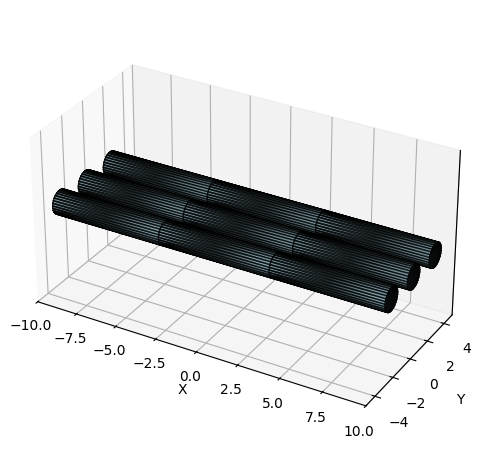

In [7]:
plot_mesh(mesh, [Lx, Ly, Lz], figsize=(8, 5))

**Tip**: Test if the tesseract works with tesseract jax as well. Abstract eval might or others things can be broken even if the tesseract works otherwise.

In [9]:
design_out = apply_tesseract(
    design_tess,
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    },
)

Starting Jacobian precomputation thread...


**Tip**: When defining custom VJP where a full Jacobian is constructed, add a jacobian endpoint for debugging purposes. The vjp endpoint can then simply call the jacobian endpoint and do a vector-matrix product.

In [10]:
jac = design_tess.jacobian(
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    },
    jac_inputs = ["differentiable_parameters"],
    jac_outputs = ["sdf"],
)

Using precomputed Jacobian...
Waiting for Jacobian precomputation to finish...
Jacobian precomputation finished.
Jacobian shape: (36, 128, 64, 64) and type: float32


**Tip**: Visualize entries of the Jacobian to verify correctness. Try to see if the Jacobian entries match your intuition about how variation in the input parameters should affect the output field.


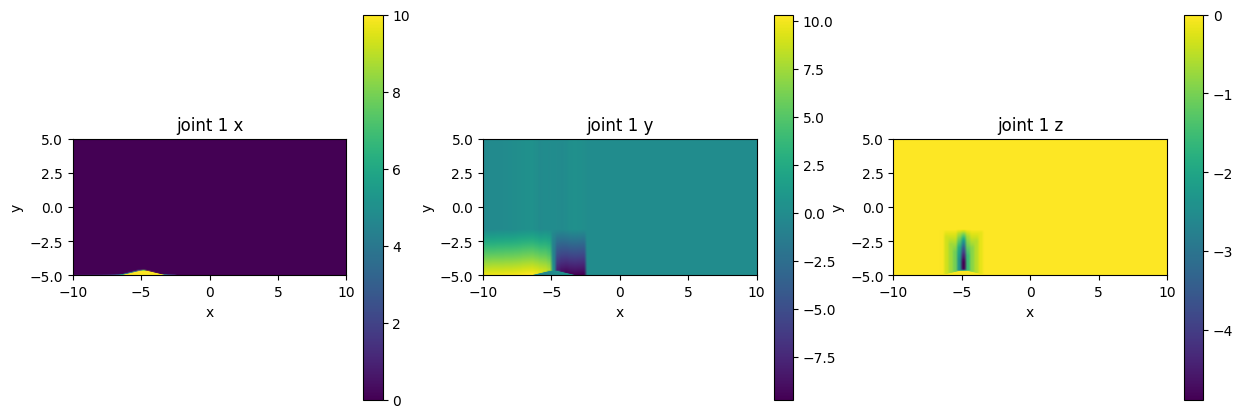

In [11]:
# plot first 3 entries of the Jacobian
jacobian_entries = jac["sdf"]["differentiable_parameters"][:3]
fig, axes = plt.subplots(1, 3, figsize=(15, 5))
titles = ["joint 1 x", "joint 1 y", "joint 1 z"]
for i in range(3):
    im = axes[i].imshow(
        jacobian_entries[i].reshape(Nx, Ny, Nz)[:, :, Nz // 2],
        extent=(-Lx / 2, Lx / 2, -Ly / 2, Ly / 2),
        origin="lower",
    )
    axes[i].set_title(titles[i])
    # label axes
    axes[i].set_xlabel("x")
    axes[i].set_ylabel("y")
    fig.colorbar(im, ax=axes[i])
    
plt.show()

**Tip**: Test the standalone vjp.


In [12]:
cotan = design_tess.vector_jacobian_product(
    {
        "differentiable_parameters": initial_params,
        **design_inputs,
    },
    vjp_inputs = ["differentiable_parameters"],
    vjp_outputs = ["sdf"],
    cotangent_vector = {
        "sdf": jnp.ones_like(sdf)
    }
)

Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (36, 128, 64, 64) and type: float32


**Tip**: Test the vjp in conjunction with jax.


In [13]:
primals, vjp_fun = jax.vjp(
    lambda params: apply_tesseract(
        design_tess,
        {
            "differentiable_parameters": params,
            **design_inputs,
        },
    )["sdf"],
    initial_params,
)

Starting Jacobian precomputation thread...


In [14]:

cotan = vjp_fun(jnp.ones_like(sdf))[0]

Using precomputed Jacobian...
Waiting for Jacobian precomputation to finish...
Jacobian precomputation finished.
Jacobian shape: (36, 128, 64, 64) and type: float32


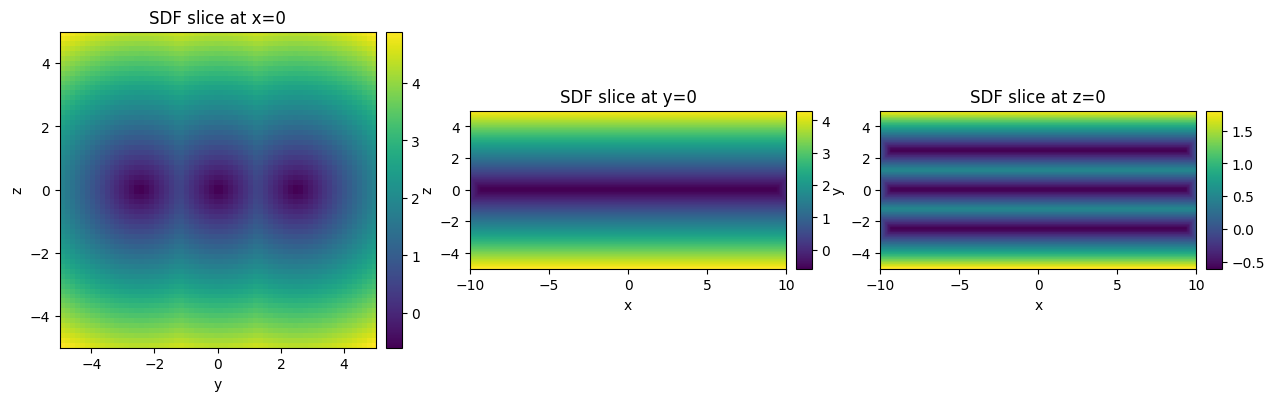

In [15]:
plot_grid(sdf, Lx, Ly, Lz, Nx, Ny, Nz)

To generate a smooth density field from the SDF field, we define a specific function that uses a sigmoid internally.

rho min: 5.256047153068266e-09, rho max: 0.9493273496627808


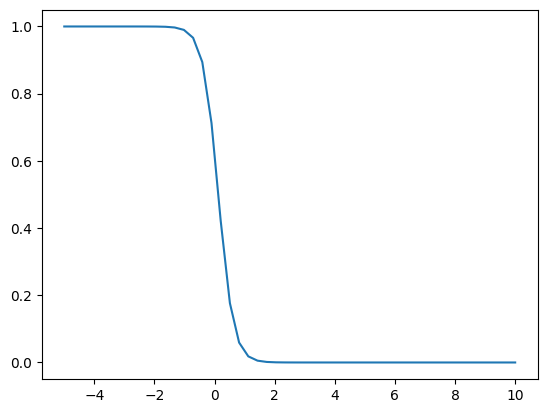

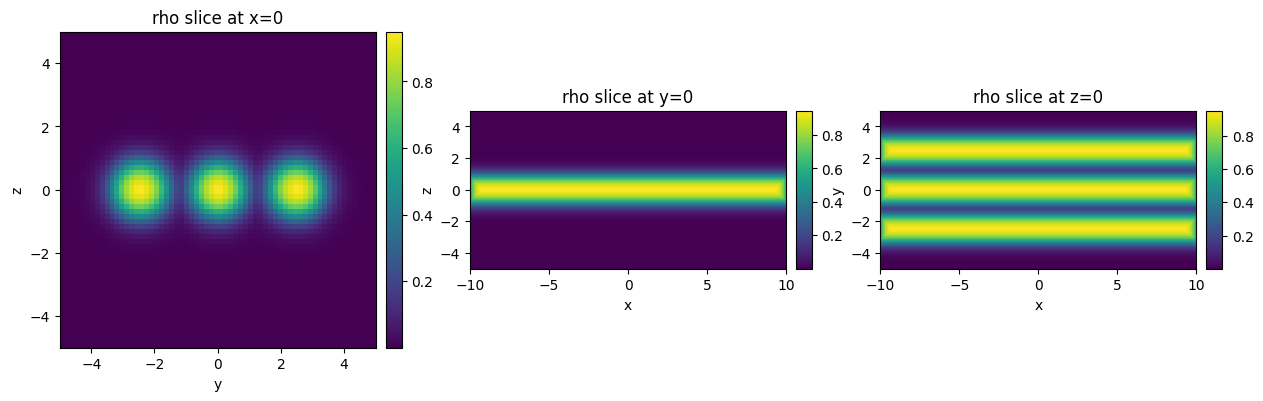

In [8]:
def sdf_to_rho(
    sdf: jnp.ndarray, scale: float = 2.0, offset: float = 0.1
) -> jnp.ndarray:
    """Convert signed distance function to material density using sigmoid.

    Args:
        sdf: Signed distance function values.
        scale: Sigmoid steepness (higher = sharper transition).
        offset: SDF value where density = 0.5.

    Returns:
        Material density field in [0,1].
    """
    return 1 / (1 + jnp.exp(scale * sdf - offset))


rho_scale = 4
rho_offset = 0.5
# plot the functions
sdfs = jnp.linspace(-5, 10)
rhos = sdf_to_rho(sdfs, scale=rho_scale, offset=rho_offset)

plt.plot(sdfs, rhos)

rho = sdf_to_rho(sdf, scale=rho_scale, offset=rho_offset)

plot_grid(rho, Lx, Ly, Lz, Nx, Ny, Nz, "rho")
print(f"rho min: {jnp.min(rho)}, rho max: {jnp.max(rho)}")

Sizing field min: 0.625, max: 2.5


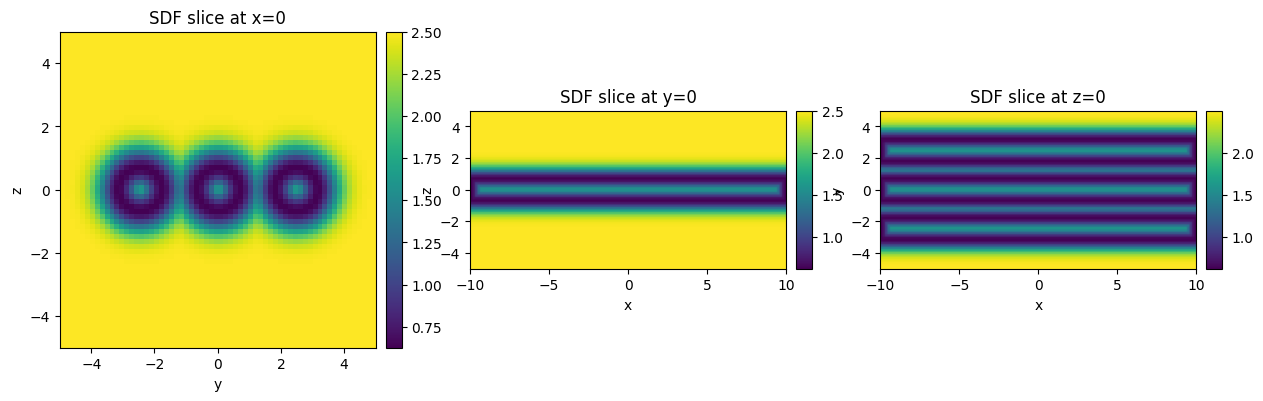

In [9]:
def sizing_field(
    sdf: jnp.ndarray, min_size: float = 0.1, max_size: float = 1.0, scale: float = 2.0
) -> jnp.ndarray:
    """Generate a sizing field from the signed distance function.

    The field is low (size = min_size) near the structure (sdf=0) and high (size = max_size) far from it.

    Args:
        sdf: Signed distance function values.
        min_size: Minimum element size near the structure.
        max_size: Maximum element size far from the structure.
        scale: Controls the transition steepness.

    Returns:
        Sizing field values.
    """

    def gauss(x: jnp.ndarray, mu: float, sigma: float) -> jnp.ndarray:
        return jnp.exp(-0.5 * ((x - mu) / sigma) ** 2)

    normalized_sdf = 1 - gauss(sdf, 0.0, 1.0 / scale)
    return min_size + (max_size - min_size) * normalized_sdf


sizing_min = Lx / 32
sizing_max = Lx / 8
sizing_scale = 2.0
sizing = sizing_field(sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale)
plot_grid(sizing, Lx, Ly, Lz, Nx, Ny, Nz)
print(f"Sizing field min: {sizing.min()}, max: {sizing.max()}")

## Adpative Hex Meshing Tesseract

In [10]:
hex_tess = Tesseract.from_tesseract_api("hex_mesh/tesseract_api.py")

In [11]:
max_points = 30000
max_cells = 30000

mesher_out = apply_tesseract(
    hex_tess,
    {
        "domain_size": [Lx, Ly, Lz],
        "sizing_field": sizing,
        "field_values": rho,
        "max_subdivision_levels": 3,
        "max_points": max_points,
        "max_cells": max_cells,
    },
)
print(
    f"Mesh points: {mesher_out['mesh']['n_points']}, Mesh faces: {mesher_out['mesh']['n_faces']}"
)
pts = mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]]
hex_cells = mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]]

hex_mesh = mesher_out["mesh"]

print(jnp.max(mesher_out["mesh_cell_values"]))
print(mesher_out["mesh_cell_values"].shape)

Done building mesh
Mesh points: 10231, Mesh faces: 7952
0.91622925
(30000,)


E0127 16:51:55.059554    6867 hlo_lexer.cc:443] Failed to parse int literal: 585130609056164673585


**Tip**: Export to VTK and visualize meshes in Paraview to verify correctness.


In [12]:
from utils import hex_to_pyvista

pv_mesh = hex_to_pyvista(pts=hex_mesh["points"].at[: hex_mesh["n_points"]].get(),
    faces=hex_mesh["faces"].at[: hex_mesh["n_faces"]].get(),
    cell_data={"values": mesher_out["mesh_cell_values"].at[: mesher_out["mesh"]["n_faces"]].get()}  )

# store mesh with pyvista
pv_mesh.save("hex_mesh.vtk")


**Tip**: Use "debugging fields" as cotangents to verify that the VJP map is working.

**Tip**: VJP functions, when mapping from one to another representation in the same 3D space can actually be achieved in creative ways. For the mesher we can either use AD or a simple interpolation of cotangents to go from mesh to grid

In [21]:
primals, vjp_fun = jax.vjp(
    lambda rho_: apply_tesseract(
        hex_tess,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,
            "field_values": rho_,
            "max_subdivision_levels": 3,
            "max_points": max_points,
            "max_cells": max_cells,
        },  
    )["mesh_cell_values"],
    rho)

cotan_prev = jnp.ones_like(mesher_out["mesh_cell_values"])
# lets add some sine fluctuations to the cotan
cotan_prev += 0.1 * jnp.sin(0.001 * jnp.arange(cotan_prev.size))
cotan = vjp_fun(cotan_prev)[0]

Done building mesh


**Tip**: Sometimes values are cell centered, sometimes node centered.

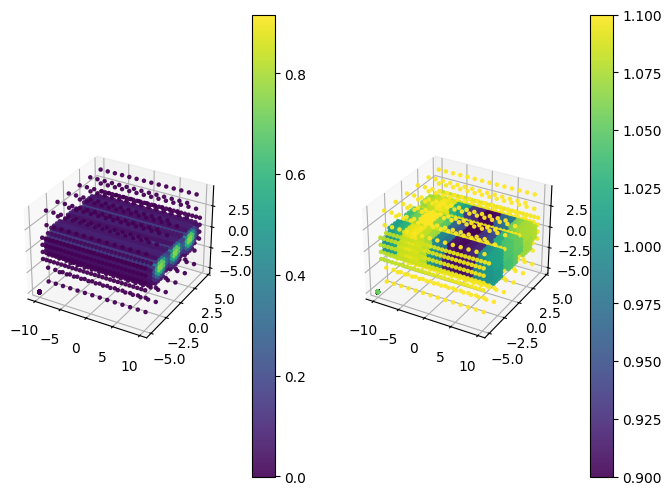

In [22]:
# lets make a scatter plot of the mesh cell values as colors
fig, axs = plt.subplots(1, 2, figsize=(8, 6), subplot_kw={"projection": "3d"})
pts_coords = hex_mesh["points"]
hex_cells = hex_mesh["faces"]
center_points = jnp.mean(pts_coords[hex_cells], axis=1)
rho_mesh = rho.flatten()
scat = axs[0].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=mesher_out["mesh_cell_values"],
    s=5,
    alpha=0.9,
    cmap="viridis",
)
# colorbar
cbar = plt.colorbar(scat, ax=axs[0], pad=0.1)


# and the otan_prev values
scat2 = axs[1].scatter(
    center_points[:, 0],
    center_points[:, 1],
    center_points[:, 2],
    c=cotan_prev,
    s=5,
    alpha=0.9,
    cmap="viridis",
)
# colorbar
cbar2 = plt.colorbar(scat2, ax=axs[1], pad=0.1)


Text(0, 0.5, 'Y')

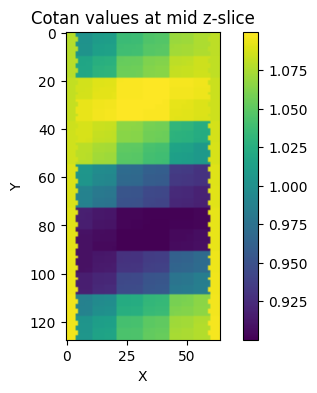

In [23]:
# we can also look at the cotan values after the hex mesher using a imshow
plt.figure(figsize=(6, 4))
plt.imshow(cotan.reshape((Nx, Ny, Nz))[:, :, Nz // 2], cmap="viridis")
plt.colorbar()
plt.title("Cotan values at mid z-slice")
plt.xlabel("X")
plt.ylabel("Y")

## Boundary Conditions

**Tip**: Make sure to visualize the boundary conditions to verify correctness.

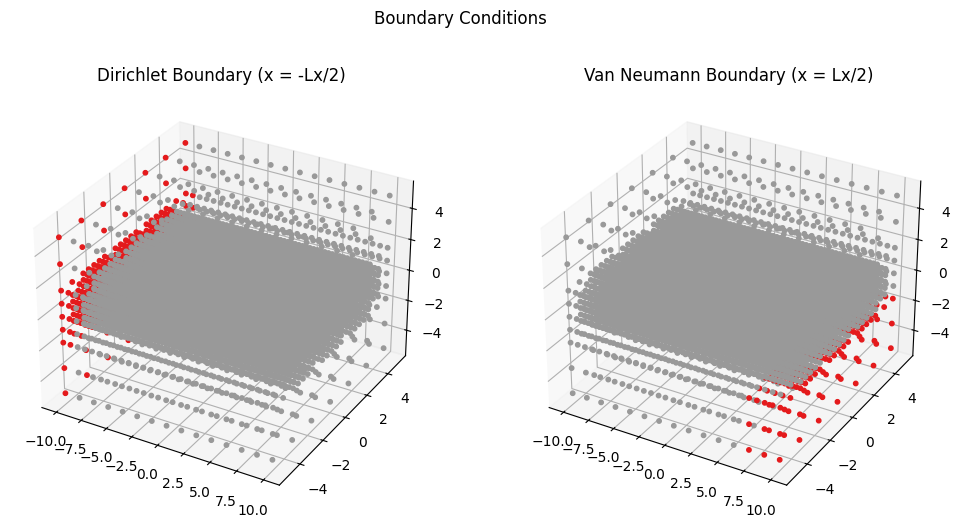

In [13]:
# Lets setup the boundary conditions


def get_boundary_masks(
    mesh: dict, Lx: float, Lz: float
) -> tuple[jnp.ndarray, jnp.ndarray]:
    """Get boundary condition masks for the adaptive mesh.

    Args:
        mesh: Dictionary containing 'points' array.
        Lx: Size of the domain in x-direction.
        Lz: Size of the domain in z-direction.

    Returns:
        dirichlet_mask: Boolean array for Dirichlet boundary condition.
        von_neumannn_mask: Boolean array for Van Neumann boundary condition.
    """
    pts = mesh["points"]

    dirichlet_mask = pts[:, 0] <= -Lx / 2 + Lx / 20
    von_neumann_mask = jnp.logical_and(
        jnp.isclose(pts[:, 0], Lx / 2, atol=Lz / 3),
        jnp.isclose(pts[:, 2], -Lz / 2, atol=Lz / 3),
    )

    return dirichlet_mask, von_neumann_mask


dirichlet_mask, von_neumann_mask = get_boundary_masks(hex_mesh, Lx, Lz)

fig, axs = plt.subplots(1, 2, subplot_kw={"projection": "3d"}, figsize=(12, 6))
# set the colormap to Set1
plt.suptitle("Boundary Conditions")
# remove the axis ticks
pts = hex_mesh["points"][: hex_mesh["n_points"]]

axs[0].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(dirichlet_mask[: hex_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[0].set_title("Dirichlet Boundary (x = -Lx/2)")

axs[1].scatter(
    pts[:, 0],
    pts[:, 1],
    pts[:, 2],
    c=jnp.where(von_neumann_mask[: hex_mesh["n_points"]], 0.1, 0.2),
    s=10,
    alpha=1.0,
    cmap="Set1",
)
axs[1].set_title("Van Neumann Boundary (x = Lx/2)")

# convert to int arrays for tesseract input
dirichlet_mask = dirichlet_mask.astype(jnp.int32)
von_neumann_mask = von_neumann_mask.astype(jnp.int32)

## Finite Element Analysis

In [14]:
compliance = apply_tesseract(
    fem_tess,
    {
        "rho": jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1),
        "hex_mesh": hex_mesh,
        "dirichlet_mask": dirichlet_mask,
        "dirichlet_values": jnp.array([0.0]),
        "von_neumann_mask": von_neumann_mask,
        "von_neumann_values": jnp.array([[0.0, 0.0, 1.0]]) / jnp.sum(von_neumann_mask),
    },
)["compliance"]
print(f"Compliance: {compliance:.4f}")

[01-27 16:51:56][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-27 16:51:56][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[01-27 16:51:56][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[01-27 16:51:56][DEBUG] jax_fem: Done pre-computations, took 0.554161787033081 [s]
[01-27 16:51:56][INFO] jax_fem: Solving a problem with 7952 cells, 10231x3 = 30693 dofs.
[01-27 16:51:56][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[01-27 16:51:57][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-27 16:51:57][DEBUG] jax_fem: Start timing
[01-27 16:51:57][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-27 16:51:58][DEBUG] jax_fem: Function split_and_compute_cell took 0.6509 seconds
[01-27 16:51:59][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-27 16:51:59][DEBUG] jax_fem: Before, l_2 res = 0.2701353631345259, relative l_2 r

Compliance: 0.1004


**Tip**: With jax its not straight forward to recover gradients, as the data is passed around in XLA. However, we can use jax callbacks to get access to numpy arrays for debugging purposes.

**Tip**: Jaxs stop_gradient does not stop gradients on integer arrays. We are using a custom stop_gradient function for that purpose.

In [15]:
from jax import custom_vjp

grad_storage = {}


def store_values(x, x_dot, hash_val: int):
    global grad_storage
    print("Storing values in hash", hash_val)
    grad_storage[int(hash_val)] = (x, x_dot)


@custom_vjp
def identity_and_store_grads(x, hash_val: int):
    return x


def identity_fwd(x, hash_val):
    return x, (x, hash_val)


def identity_bwd(residuals, g):
    x, hash_val = residuals
    jax.debug.callback(store_values, x, g, hash_val, ordered=False)
    return (g, None)


identity_and_store_grads.defvjp(identity_fwd, identity_bwd)

In [16]:
max_points = 15000
max_cells = 15000


def loss(
    params: jnp.ndarray,
    iteration: int = 0,
) -> tuple[float, dict]:
    """Compute structural compliance for given bar parameters.

    Args:
        params: Bar parameter array with shape (n_chains, n_nodes, 3).
        iteration: current optim iteration.

    Returns:
        Structural compliance (scalar). Lower values indicate better performance.
    """
    # Generate signed distance field from design parameters
    # params = identity_and_store_grads(params, iteration + 0)
    design_out = apply_tesseract(
        design_tess,
        {"differentiable_parameters": params.flatten(), **design_inputs},
    )

    sdf = design_out["sdf"]

    # make grad wrt to sdf field accessible via callback
    sdf = identity_and_store_grads(sdf, iteration + 100)

    # Convert SDF to material density distribution
    rho_grid = sdf_to_rho(sdf, scale=2)

    sizing = sizing_field(
        sdf, min_size=sizing_min, max_size=sizing_max, scale=sizing_scale
    )
    sizing = jax.lax.stop_gradient(sizing)

    mesher_out = apply_tesseract(
        hex_tess,
        {
            "domain_size": [Lx, Ly, Lz],
            "sizing_field": sizing,  # jnp.ones_like(sdf) * (Lx / 10),
            "field_values": rho_grid,
            "max_subdivision_levels": 2,
            "max_points": max_points,
            "max_cells": max_cells,
        },
    )

    rho_cell = jnp.expand_dims(mesher_out["mesh_cell_values"], axis=-1)

    mesh = stop_grads_int(mesher_out["mesh"])

    dirichlet_mask, von_neumann_mask = get_boundary_masks(mesh, Lx, Lz)

    von_neumann_mask = jax.lax.stop_gradient(von_neumann_mask)
    dirichlet_mask = jax.lax.stop_gradient(dirichlet_mask)
    dirichlet_values = jnp.array([0.0])
    von_neumann_values = jnp.array([[0.0, 0.0, 1.0]]) / jnp.sum(von_neumann_mask)

    # Lets make gradients with respect to rho_cell accessible via callback
    rho_cell = identity_and_store_grads(rho_cell, iteration + 200)

    c = apply_tesseract(
        fem_tess,
        {
            "rho": rho_cell,
            "hex_mesh": mesh,
            "dirichlet_mask": dirichlet_mask,
            "dirichlet_values": dirichlet_values,
            "von_neumann_mask": von_neumann_mask,
            "von_neumann_values": von_neumann_values,
        },
    )["compliance"]

    surface_mesh = {
        "points": design_out["mesh"]["points"][: design_out["mesh"]["n_points"]],
        "faces": design_out["mesh"]["faces"][: design_out["mesh"]["n_faces"]],
    }

    hex_mesh = {
        "points": mesher_out["mesh"]["points"][: mesher_out["mesh"]["n_points"]],
        "faces": mesher_out["mesh"]["faces"][: mesher_out["mesh"]["n_faces"]],
        "rho": mesher_out["mesh_cell_values"][: mesher_out["mesh"]["n_faces"]],
    }

    return c, {
        "sdf": sdf,
        "rho_grid": rho_grid,
        "sizing": sizing,
        "hex_mesh": hex_mesh,
        "surface_mesh": surface_mesh,
    }


grad_fn = jax.value_and_grad(loss, has_aux=True)

In [17]:
def optimize(
    diffable_params: jnp.ndarray,
    iterations: int = 20,
) -> tuple[list, list, list]:
    """Optimize a design defined by parameters."""
    params = diffable_params.copy()
    loss_hist = []
    params_hist = []
    aux_hist = []

    optmizer = optax.adam(learning_rate=0.02)
    opt_state = optmizer.init(params)

    for i in range(iterations):
        (loss_value, aux), grads = grad_fn(params, iteration=i)

        grads = grads / jnp.max(grads)
        updates, opt_state = optmizer.update(
            grads, opt_state, params, value=loss_value, grad=grads, value_fn=loss
        )
        params = optax.apply_updates(params, updates)
        params = params.at[::3].set(initial_params.at[::3].get())

        loss_hist.append(loss_value)
        params_hist.append(params)
        aux_hist.append(aux)

        print(f"Iteration {i + 1}, Loss: {loss_value:.4f}")

    return loss_hist, params_hist, aux_hist

We can now run an optmization on the ranomly initialized geometry. The main bottleneck of this pipeline is the SDF compuations which has signifcant overhead slowing this optimization down. Exeucting this cell can take up to an hour.

In [18]:
n_steps = 5
loss_hist, params_hist, aux_hist = optimize(initial_params, iterations=n_steps)

Starting Jacobian precomputation thread...
Done building mesh


[01-27 16:52:40][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-27 16:52:40][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[01-27 16:52:40][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[01-27 16:52:41][DEBUG] jax_fem: Done pre-computations, took 0.5076367855072021 [s]
[01-27 16:52:41][INFO] jax_fem: Solving a problem with 1680 cells, 2305x3 = 6915 dofs.
[01-27 16:52:41][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[01-27 16:52:42][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-27 16:52:42][DEBUG] jax_fem: Start timing
[01-27 16:52:42][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-27 16:52:42][DEBUG] jax_fem: Function split_and_compute_cell took 0.3268 seconds
[01-27 16:52:43][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-27 16:52:43][DEBUG] jax_fem: Before, l_2 res = 0.5381651892864066, relative l_2 re

Storing values in hash 200
Storing values in hash 100
Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (36, 128, 64, 64) and type: float32
Iteration 1, Loss: 0.3303
Starting Jacobian precomputation thread...


[01-27 16:53:59][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-27 16:53:59][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[01-27 16:53:59][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[01-27 16:53:59][DEBUG] jax_fem: Done pre-computations, took 0.04324674606323242 [s]
[01-27 16:53:59][INFO] jax_fem: Solving a problem with 1680 cells, 2305x3 = 6915 dofs.
[01-27 16:53:59][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[01-27 16:53:59][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-27 16:53:59][DEBUG] jax_fem: Start timing
[01-27 16:53:59][DEBUG] jax_fem: Computing cell Jacobian and cell residual...


Done building mesh


[01-27 16:53:59][DEBUG] jax_fem: Function split_and_compute_cell took 0.2512 seconds
[01-27 16:54:00][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-27 16:54:00][DEBUG] jax_fem: Before, l_2 res = 0.5381651892864066, relative l_2 res = 1.0
[01-27 16:54:00][DEBUG] jax_fem: Solving linear system...
[01-27 16:54:00][DEBUG] jax_fem: Scipy Solver - Solving linear system with UMFPACK
[01-27 16:54:00][DEBUG] jax_fem: Scipy Solver - Finished solving, linear solve res = 7.284504242579562e-12
[01-27 16:54:00][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-27 16:54:00][DEBUG] jax_fem: Function split_and_compute_cell took 0.0993 seconds
[01-27 16:54:00][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-27 16:54:00][DEBUG] jax_fem: l_2 res = 7.176472403789616e-12, relative l_2 res = 1.3335073592005156e-11
[01-27 16:54:00][INFO] jax_fem: Solve took 1.2271690368652344 [s]
[01-27 16:54:00][INFO] jax_fem: max of dofs = 0.02970829330340004
[01-27 16:54:00][INFO] jax_fem

Storing values in hash 201
Storing values in hash 101
Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (36, 128, 64, 64) and type: float32
Iteration 2, Loss: 0.3283
Starting Jacobian precomputation thread...
Done building mesh


[01-27 16:55:07][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-27 16:55:07][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[01-27 16:55:07][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[01-27 16:55:08][DEBUG] jax_fem: Done pre-computations, took 0.35598158836364746 [s]
[01-27 16:55:08][INFO] jax_fem: Solving a problem with 1890 cells, 2549x3 = 7647 dofs.
[01-27 16:55:08][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[01-27 16:55:09][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-27 16:55:09][DEBUG] jax_fem: Start timing
[01-27 16:55:09][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-27 16:55:09][DEBUG] jax_fem: Function split_and_compute_cell took 0.5100 seconds
[01-27 16:55:10][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-27 16:55:10][DEBUG] jax_fem: Before, l_2 res = 0.22497212336169004, relative l_2 

Storing values in hash 202
Storing values in hash 102
Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (36, 128, 64, 64) and type: float32
Iteration 3, Loss: 0.1651
Starting Jacobian precomputation thread...
Done building mesh


[01-27 16:56:33][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-27 16:56:33][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[01-27 16:56:33][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[01-27 16:56:34][DEBUG] jax_fem: Done pre-computations, took 0.5351908206939697 [s]
[01-27 16:56:34][INFO] jax_fem: Solving a problem with 2023 cells, 2719x3 = 8157 dofs.
[01-27 16:56:34][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[01-27 16:56:35][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-27 16:56:35][DEBUG] jax_fem: Start timing
[01-27 16:56:35][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-27 16:56:35][DEBUG] jax_fem: Function split_and_compute_cell took 0.5042 seconds
[01-27 16:56:36][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-27 16:56:36][DEBUG] jax_fem: Before, l_2 res = 0.22497212336169004, relative l_2 r

Storing values in hash 203
Storing values in hash 103
Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (36, 128, 64, 64) and type: float32
Iteration 4, Loss: 0.1622
Starting Jacobian precomputation thread...
Done building mesh


[01-27 16:58:06][DEBUG] jax_fem: Computing shape function values, gradients, etc.
[01-27 16:58:06][DEBUG] jax_fem: ele_type = HEX8, quad_points.shape = (num_quads, dim) = (8, 3)
[01-27 16:58:06][DEBUG] jax_fem: face_quad_points.shape = (num_faces, num_face_quads, dim) = (6, 4, 3)
[01-27 16:58:06][DEBUG] jax_fem: Done pre-computations, took 0.38401198387145996 [s]
[01-27 16:58:06][INFO] jax_fem: Solving a problem with 2107 cells, 2809x3 = 8427 dofs.
[01-27 16:58:06][INFO] jax_fem: Element type is HEX8, using 8 quad points per element.
[01-27 16:58:07][DEBUG] jax_fem: Calling the row elimination solver for imposing Dirichlet B.C.
[01-27 16:58:07][DEBUG] jax_fem: Start timing
[01-27 16:58:07][DEBUG] jax_fem: Computing cell Jacobian and cell residual...
[01-27 16:58:08][DEBUG] jax_fem: Function split_and_compute_cell took 0.5465 seconds
[01-27 16:58:08][DEBUG] jax_fem: Creating sparse matrix with scipy...
[01-27 16:58:08][DEBUG] jax_fem: Before, l_2 res = 0.22497212336169004, relative l_2 

Storing values in hash 204
Storing values in hash 104
Using precomputed Jacobian...
Jacobian precomputation finished.
Jacobian shape: (36, 128, 64, 64) and type: float32
Iteration 5, Loss: 0.1593


Text(0.5, 1.0, 'Compliance over Optimization')

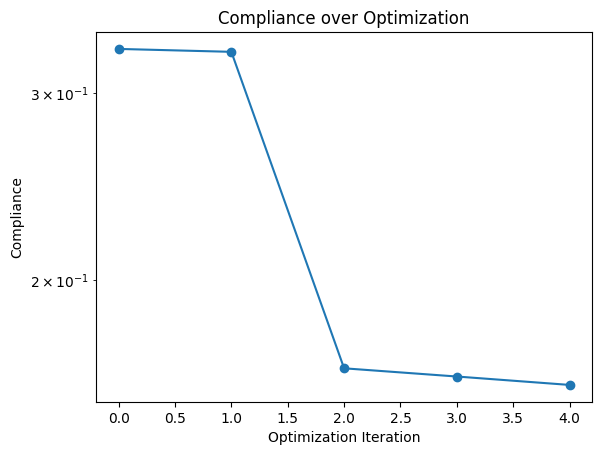

In [19]:
plt.plot(loss_hist, marker="o")
plt.yscale("log")
plt.xlabel("Optimization Iteration")
plt.ylabel("Compliance")
plt.title("Compliance over Optimization")

**Tip**: Plot gradients over course of optimization to verify correctness.

**Tip**: And or store vtk animations.

--- Iteration 1 ---
SDF primals shape: (128, 64, 64), grads shape: (128, 64, 64)
Number of mesh cells: 1680
Rho primals shape: (15000, 1), grads shape: (1680, 1)


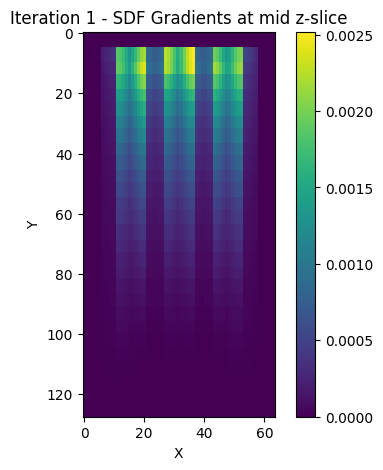

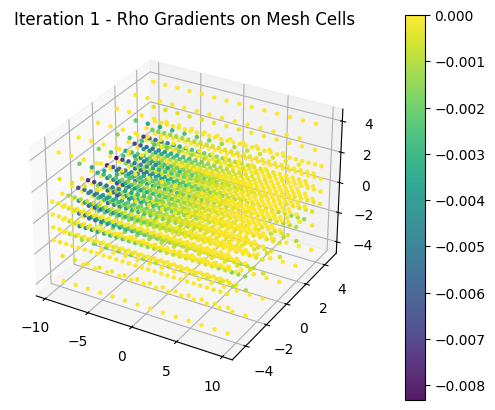

--- Iteration 2 ---
SDF primals shape: (128, 64, 64), grads shape: (128, 64, 64)
Number of mesh cells: 1680
Rho primals shape: (15000, 1), grads shape: (1680, 1)


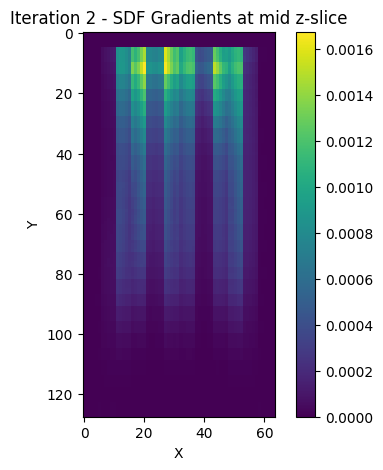

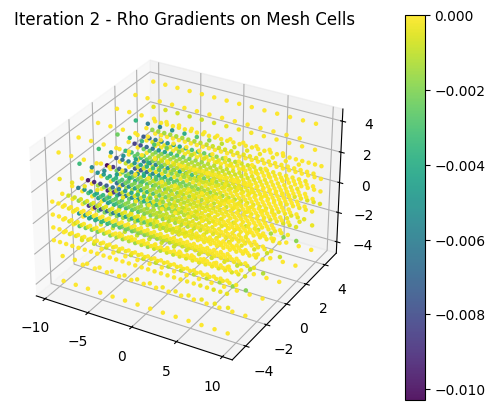

--- Iteration 3 ---
SDF primals shape: (128, 64, 64), grads shape: (128, 64, 64)
Number of mesh cells: 1890
Rho primals shape: (15000, 1), grads shape: (1890, 1)


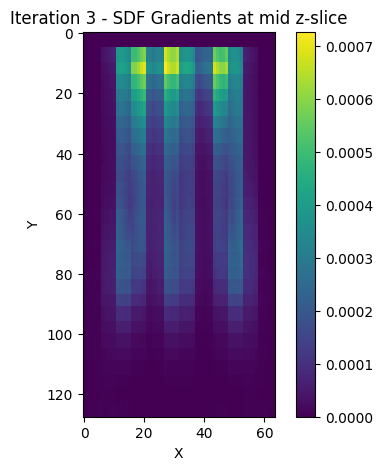

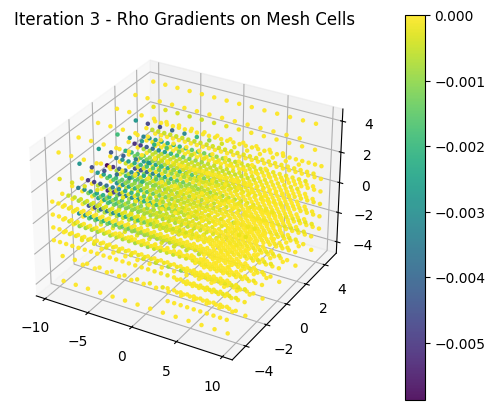

--- Iteration 4 ---
SDF primals shape: (128, 64, 64), grads shape: (128, 64, 64)
Number of mesh cells: 2023
Rho primals shape: (15000, 1), grads shape: (2023, 1)


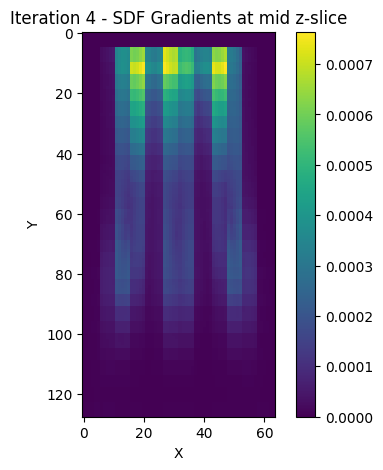

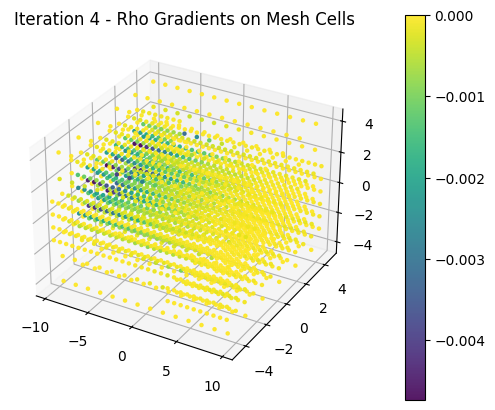

--- Iteration 5 ---
SDF primals shape: (128, 64, 64), grads shape: (128, 64, 64)
Number of mesh cells: 2107
Rho primals shape: (15000, 1), grads shape: (2107, 1)


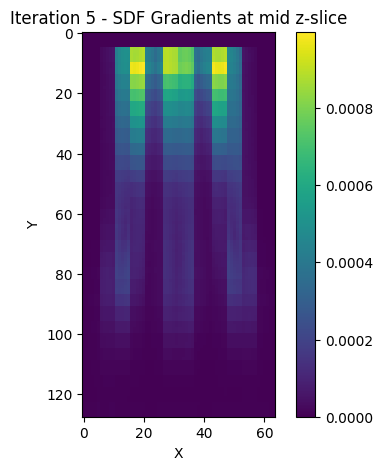

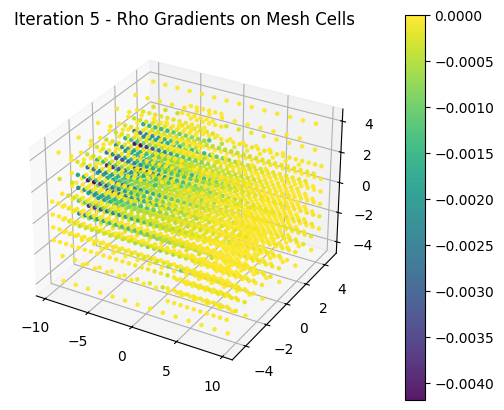

In [20]:
grad_storage.keys()
sdf_hash_start = 100 # grid
rho_hash_start = 200 # mesh cells
# primals are found in aux grid
# visualize stored gradients
# make vtk folder
vtk_out = "vtk_out/"
import os
if not os.path.exists(vtk_out):
    os.makedirs(vtk_out)

for i in range(n_steps):
    print(f"--- Iteration {i+1} ---")
    sdf_key = sdf_hash_start + i
    rho_key = rho_hash_start + i

    sdf_primals, sdf_grads = grad_storage[sdf_key]
    rho_primals, rho_grads = grad_storage[rho_key]

    print(f"SDF primals shape: {sdf_primals.shape}, grads shape: {sdf_grads.shape}")

    # visualize sdf grads
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    plt.title(f"Iteration {i+1} - SDF Gradients at mid z-slice")
    plt.imshow(sdf_grads.reshape(Nx, Ny, Nz)[:, :, Nz // 2], cmap="viridis")
    plt.colorbar()
    plt.xlabel("X")
    plt.ylabel("Y")

    # visualize with scatter plot as its a 3d mesh
    # similar to here: 
    #   and the otan_prev values
    # scat2 = axs[1].scatter(
    #     center_points[:, 0],
    #     center_points[:, 1],
    #     center_points[:, 2],
    #     c=cotan_prev,
    #     s=5,
    #     alpha=0.9,
    #     cmap="viridis",
    # )
    # # colorbar
    # cbar2 = plt.colorbar(scat2, ax=axs[1], pad=0.1)

    hex_mesh = aux_hist[i]["hex_mesh"]
    n_faces = hex_mesh["faces"].shape[0]
    print(f"Number of mesh cells: {n_faces}")

    rho_grads = rho_grads[:n_faces]
   # plot it
    print(f"Rho primals shape: {rho_primals.shape}, grads shape: {rho_grads.shape}")
    fig = plt.figure(figsize=(6, 5))
    ax = fig.add_subplot(111, projection='3d')
    pts_coords = hex_mesh["points"]
    hex_cells = hex_mesh["faces"]
    center_points = jnp.mean(pts_coords[hex_cells], axis=1)
    scat = ax.scatter(
        center_points[:, 0],
        center_points[:, 1],
        center_points[:, 2],
        c=rho_grads,
        s=5,
        alpha=0.9,
        cmap="viridis",
    )
    cbar = plt.colorbar(scat, ax=ax, pad=0.1)
    ax.set_title(f"Iteration {i+1} - Rho Gradients on Mesh Cells")

    vtk_mesh = hex_to_pyvista(pts=hex_mesh["points"],
        faces=hex_mesh["faces"],
        cell_data={"rho_grads": rho_grads, "rho" : hex_mesh["rho"][:n_faces]}  )

    vtk_mesh.save(f"{vtk_out}/iteration_{i+1}_mesh.vtk")

    plt.show()
   

### Optimization Postprocess

In order to visualize the optmization, we generate a gif showing the evolution of the surface mesh.

In [22]:
# lets visualize the 3d meshes over the optimization
for i, aux in enumerate(aux_hist):
    plot_mesh(
        aux["surface_mesh"],
        save_path=f"tmp_img/mesh_optim_{i:03d}.png",
        bounds=[Lx, Ly, Lz],
    )

images = []

for i in range(len(aux_hist)):
    filename = f"tmp_img/mesh_optim_{i:03d}.png"
    images.append(imageio.imread(filename))
    print(f"Added {filename} to gif.")
# make sure the gif repeats forever
imageio.mimsave("imgs/mesh_optim.gif", images, fps=10, loop=0)

Added tmp_img/mesh_optim_000.png to gif.
Added tmp_img/mesh_optim_001.png to gif.
Added tmp_img/mesh_optim_002.png to gif.
Added tmp_img/mesh_optim_003.png to gif.
Added tmp_img/mesh_optim_004.png to gif.


/tmp/ipykernel_6867/1108791225.py:13: DeprecationWarning: Starting with ImageIO v3 the behavior of this function will switch to that of iio.v3.imread. To keep the current behavior (and make this warning disappear) use `import imageio.v2 as imageio` or call `imageio.v2.imread` directly.
  images.append(imageio.imread(filename))


![Workflow](imgs/mesh_optim.gif)